In [131]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [132]:
MAXIMUM_Q_VALUE = 0.005

In [133]:
psms_df = pd.read_csv('/Users/darylwilding-mcbride/Downloads/190719_Hela_Ecoli.percolator.target.psms.txt', sep='\t')
psms_df = psms_df[psms_df['percolator q-value'] <= MAXIMUM_Q_VALUE]

In [134]:
psms_df[psms_df.file_idx == 0].sort_values(by='scan').head()

,file_idx,scan,charge,spectrum precursor m/z,spectrum neutral mass,peptide mass,percolator score,percolator q-value,percolator PEP,total matches/spectrum,sequence,protein id,flanking aa
22071,0,3,2,871.9112,1741.8078,1742.8120,1.074627,0.000003,1.274665e-09,122855,AMGIMNSFVNDIFER,"sp|Q5QNW6|H2B2F_HUMAN,sp|Q99879|H2B1M_HUMAN,sp...",KI
380397,0,4,2,901.9452,1801.8758,1802.8799,0.499210,0.000003,5.460350e-05,122855,GITINTSHVEYDTPTR,"sp|P0CE48|EFTU2_ECOLI,sp|P0CE47|EFTU1_ECOLI",RH
18633,0,5,3,801.0837,2400.2291,2401.2336,1.095587,0.000003,8.642908e-10,122855,ANDAAGDGTTTATVLAQAIITEGLK,sp|P0A6F5|CH60_ECOLI,KA
446,0,6,2,1093.0845,2184.1545,2128.1350,1.488718,0.000003,5.911491e-13,122855,IPISGIAGDQQAALFGQLCVK,sp|P0A6F3|GLPK_ECOLI,RE
191655,0,7,2,965.5864,1929.1583,1930.1615,0.722457,0.000003,8.721569e-07,122855,VTIAQGGVLPNIQAVLLPK,"sp|Q99878|H2A1J_HUMAN,sp|Q9BTM1|H2AJ_HUMAN,sp|...",KK


In [135]:
mapping = []
with open('/Users/darylwilding-mcbride/Downloads/percolator-stdout.log') as f:
    lines = f.readlines()
    for line in lines:
        if line.startswith('INFO: Assigning index'):
            splits = line.split(' ')
            percolator_index = int(splits[3])
            comet_filename = splits[5]
            base_name = comet_filename.split('/')[-1].split('.')[0]
            mapping.append((percolator_index, base_name))

In [136]:
mapping

[(0, '190719_Hela_Ecoli_1to3_06'),
 (1, '190719_Hela_Ecoli_1to1_07'),
 (2, '190719_Hela_Ecoli_1to3_07'),
 (3, '190719_Hela_Ecoli_1to1_09'),
 (4, '190719_Hela_Ecoli_1to3_05'),
 (5, '190719_Hela_Ecoli_1to3_09'),
 (6, '190719_Hela_Ecoli_1to1_04'),
 (7, '190719_Hela_Ecoli_1to3_08'),
 (8, '190719_Hela_Ecoli_1to3_04'),
 (9, '190719_Hela_Ecoli_1to3_10'),
 (10, '190719_Hela_Ecoli_1to1_03'),
 (11, '190719_Hela_Ecoli_1to1_10'),
 (12, '190719_Hela_Ecoli_1to1_06'),
 (13, '190719_Hela_Ecoli_1to3_03'),
 (14, '190719_Hela_Ecoli_1to3_01'),
 (15, '190719_Hela_Ecoli_1to3_02'),
 (16, '190719_Hela_Ecoli_1to1_01'),
 (17, '190719_Hela_Ecoli_1to1_02'),
 (18, '190719_Hela_Ecoli_1to1_08'),
 (19, '190719_Hela_Ecoli_1to1_05')]

In [137]:
# sequence_counts = []
# for group_name,group_df in psms_df.groupby('sequence'):
#     print(group_name, group_df.file_idx.value_counts().to_frame())
    

In [138]:
df_l = []
for m in mapping:
    idx = m[0]
    filename = m[1]
    df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/190719_Hela_Ecoli/pkl/{}-features.pkl'.format(filename))
    df['percolator_idx'] = idx
    df['batch'] = filename.split('_')[3]
    df_l.append(df)
# make a single df from the list of dfs
features_df = pd.concat(df_l, axis=0)
features_df.drop(['candidate_phr_error','envelope','mono_adjusted','original_phr','original_phr_error','precursor_id','rt_curve_fit','rt_lower','rt_upper','scan_curve_fit','scan_lower','scan_upper'], axis=1, inplace=True)

In [139]:
percolator_df = pd.merge(psms_df, features_df, how='left', left_on=['file_idx','scan'], right_on=['percolator_idx','feature_id'])
percolator_df['human'] = percolator_df['protein id'].str.contains('HUMAN')

In [140]:
len(percolator_df)

606266

In [141]:
percolator_df.columns

Index(['file_idx', 'scan', 'charge_x', 'spectrum precursor m/z',
       'spectrum neutral mass', 'peptide mass', 'percolator score',
       'percolator q-value', 'percolator PEP', 'total matches/spectrum',
       'sequence', 'protein id', 'flanking aa', 'charge_y', 'feature_id',
       'intensity', 'intensity_full_rt_extent', 'monoisotopic_mz', 'rt_apex',
       'scan_apex', 'percolator_idx', 'batch', 'human'],
      dtype='object')

In [142]:
# sequences_l = []
# for group_name,group_df in percolator_df.groupby(['file_idx','sequence','charge_x'], as_index=False):
#     t = (group_df.iloc[0].batch,)
#     t += group_name
#     t += (group_df.intensity.max(),group_df.iloc[0].human,len(group_df))
#     sequences_l.append(t)

In [143]:
# sequences_df = pd.DataFrame(sequences_l, columns=['batch','file_idx','sequence','charge','intensity','human','count_in_file'])

In [144]:
# sequences_df.head()

In [145]:
sequence_occurences_in_batch = []
for group_name,group_df in sequences_df.groupby(['sequence','charge'], as_index=False):
    sequence_in_1to1_df = group_df[group_df.batch == '1to1']
    sequence_in_1to3_df = group_df[group_df.batch == '1to3']
    if (len(sequence_in_1to1_df) >= 5) and (len(sequence_in_1to3_df) >= 5):
        average_intensity_in_1to1 = sequence_in_1to1_df.intensity.mean()
        average_intensity_in_1to3 = sequence_in_1to3_df.intensity.mean()
        human = group_df.iloc[0].human
        t = group_name
        t += (average_intensity_in_1to1, average_intensity_in_1to3, human)
        sequence_occurences_in_batch.append(t)

In [146]:
sequence_occurences_in_batch_df = pd.DataFrame(sequence_occurences_in_batch, columns=['sequence','charge','intensity_1to1','intensity_1to3','human'])

In [147]:
sequence_occurences_in_batch_df.head()

,sequence,charge,intensity_1to1,intensity_1to3,human
0,AAAAAAAAVPSAGPAGPAPTSAAGR,2,70306.000000,56008.200000,True
1,AAAAATVVPPMVGGPPFVGPVGFGPGDR,3,50455.833333,55671.000000,True
2,AAAAAWEEPSSGNGTAR,2,367740.200000,284638.900000,True
3,AAAEDVNVTFEDQQK,2,194934.125000,78582.222222,True
4,AAAEELQEAAGAGDGATENGVQPPK,2,80061.100000,72475.000000,True


In [148]:
sequence_occurences_in_batch_df['intensity_ratio'] = np.log(sequence_occurences_in_batch_df.intensity_1to1 / sequence_occurences_in_batch_df.intensity_1to3)

In [149]:
human_df = sequence_occurences_in_batch_df[sequence_occurences_in_batch_df.human == True]
ecoli_df = sequence_occurences_in_batch_df[sequence_occurences_in_batch_df.human == False]

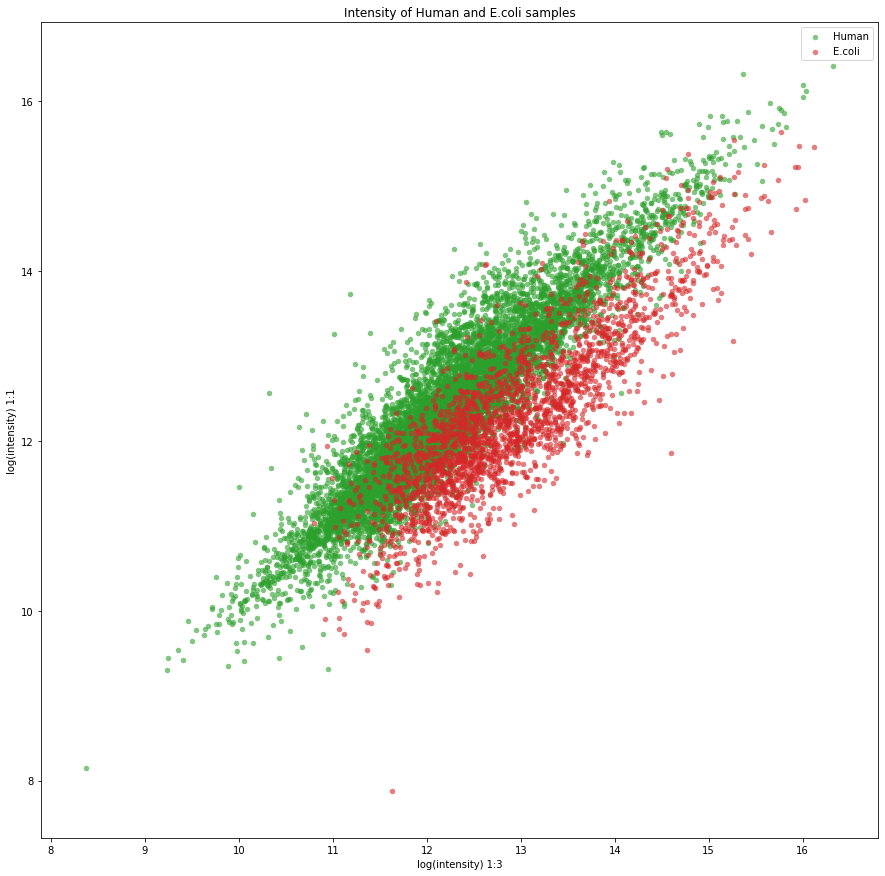

In [150]:
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Intensity of Human and E.coli samples')

ax.scatter(np.log(human_df.intensity_1to3), np.log(human_df.intensity_1to1), marker='o', color='tab:green', lw=0, s=30, alpha=0.6, label="Human")
ax.scatter(np.log(ecoli_df.intensity_1to3), np.log(ecoli_df.intensity_1to1), marker='o', color='tab:red', lw=0, s=30, alpha=0.6, label="E.coli")

plt.legend(loc='best')
plt.xlabel('log(intensity) 1:3')
plt.ylabel('log(intensity) 1:1')

plt.show()

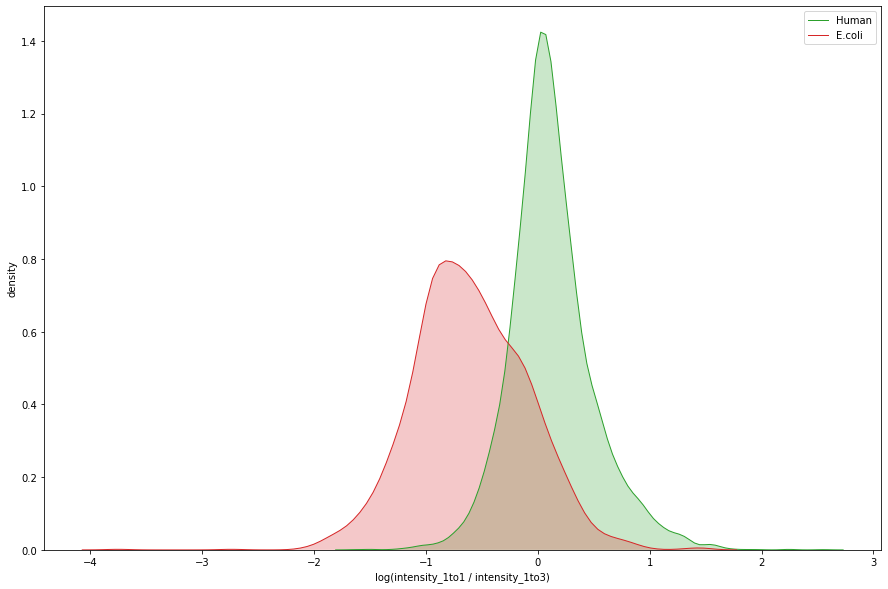

In [151]:
import seaborn as sns
plt.figure(figsize=(15, 10))

ax = sns.distplot(human_df['intensity_ratio'], hist = False, color='tab:green', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Human')
_ = sns.distplot(ecoli_df['intensity_ratio'], hist = False, color='tab:red', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'E.coli')

_ = ax.set(xlabel='log(intensity_1to1 / intensity_1to3)', ylabel='density')


Analyse mass error

In [154]:
percolator_df.columns

Index(['file_idx', 'scan', 'charge_x', 'spectrum precursor m/z',
       'spectrum neutral mass', 'peptide mass', 'percolator score',
       'percolator q-value', 'percolator PEP', 'total matches/spectrum',
       'sequence', 'protein id', 'flanking aa', 'charge_y', 'feature_id',
       'intensity', 'intensity_full_rt_extent', 'monoisotopic_mz', 'rt_apex',
       'scan_apex', 'percolator_idx', 'batch', 'human'],
      dtype='object')

In [155]:
percolator_df = percolator_df[percolator_df['peptide mass'] > 0]

In [156]:
PROTON_MASS = 1.007276
ADD_C_CYSTEINE_DA = 57.021464

Need to add mass of cysteine carbamidomethylation to the theoretical peptide mass from Percolator, for the fixed modification of carbamidomethyl

In [162]:
percolator_df['monoisotopic_mass'] = (percolator_df.monoisotopic_mz * percolator_df.charge_y) - (PROTON_MASS * percolator_df.charge_y)
percolator_df['peptide_mass_mod'] = percolator_df['peptide mass'] + (percolator_df.sequence.str.count('C') * ADD_C_CYSTEINE_DA)
percolator_df['mass_accuracy_ppm'] = (percolator_df['monoisotopic_mass'] - percolator_df['peptide_mass_mod']) / percolator_df['peptide mass'] * 10**6
percolator_df['mass_error'] = percolator_df['monoisotopic_mass'] - percolator_df['peptide_mass_mod']
subset_df = percolator_df[['peptide mass','peptide_mass_mod','monoisotopic_mass','mass_error','mass_accuracy_ppm','sequence']]

In [163]:
subset_df.tail()

,peptide mass,peptide_mass_mod,monoisotopic_mass,mass_error,mass_accuracy_ppm,sequence
606261,1574.7172,1574.717200,1574.717667,0.000467,0.296530,REEESAAAAEVEER
606262,1193.5928,1193.592800,1193.575848,-0.016952,-14.202506,TDITELEAFR
606263,1428.6568,1485.678264,1485.691695,0.013431,9.400909,DSNNLCLHFNPR
606264,1944.8483,1944.848300,1944.862946,0.014646,7.530432,QQAGAQGPGSADLEDGEMGK
606265,1629.8627,1629.862700,1629.843131,-0.019569,-12.006606,LPGGVQNFPQFSALR


In [211]:
file_idx_to_plot = 0
percolator_file_subset_df = percolator_df[percolator_df.file_idx == file_idx_to_plot].copy()

In [212]:
percolator_file_subset_df

,file_idx,scan,charge_x,spectrum precursor m/z,spectrum neutral mass,peptide mass,percolator score,percolator q-value,percolator PEP,total matches/spectrum,...,monoisotopic_mz,rt_apex,scan_apex,percolator_idx,batch,human,monoisotopic_mass,peptide_mass_mod,mass_accuracy_ppm,mass_error
0,0,2583,3,965.1373,2892.3901,2836.3813,2.142524,0.000003,3.222019e-18,122855,...,965.473055,699.30,548.76,0,1to3,False,2893.397337,2893.402764,-1.913323,-0.005427
11,0,163,3,1104.1826,3309.5260,3196.4838,1.852679,0.000003,6.943396e-16,122855,...,1104.518354,875.41,359.51,0,1to3,True,3310.533235,3310.526728,2.035561,0.006507
14,0,3217,3,965.1372,2892.3898,2836.3813,1.833616,0.000003,9.886424e-16,122855,...,965.472952,699.29,549.30,0,1to3,False,2893.397029,2893.402764,-2.021934,-0.005735
29,0,1722,2,949.4716,1896.9286,1840.9141,1.763199,0.000003,3.647072e-15,122855,...,949.975190,917.59,318.86,0,1to3,False,1897.935828,1897.935564,0.143361,0.000264
86,0,10608,3,818.0528,2451.1364,2395.1226,1.655102,0.000003,2.705177e-14,122855,...,818.388512,480.65,683.43,0,1to3,True,2452.143707,2452.144064,-0.149140,-0.000357
101,0,1221,2,948.9226,1895.8306,1896.8312,1.642638,0.000003,3.408288e-14,122855,...,949.426194,615.82,281.30,0,1to3,False,1896.837835,1896.831200,3.498063,0.006635
107,0,8214,2,1120.5120,2239.0094,2182.9881,1.639812,0.000003,3.591636e-14,122855,...,1121.015624,724.10,101.59,0,1to3,True,2240.016695,2240.009564,3.266655,0.007131
109,0,246,2,883.4488,1764.8831,1765.8886,1.639058,0.000003,3.642156e-14,122855,...,883.952478,818.84,364.59,0,1to3,False,1765.890403,1765.888600,1.021150,0.001803
122,0,5275,2,949.4716,1896.9286,1840.9141,1.622682,0.000003,4.933980e-14,122855,...,949.975205,917.59,319.55,0,1to3,False,1897.935859,1897.935564,0.160120,0.000295
125,0,16869,2,1096.9875,2191.9605,2078.9118,1.620083,0.000003,5.177549e-14,122855,...,1097.491162,799.66,175.94,0,1to3,True,2192.967772,2192.954728,6.274360,0.013044


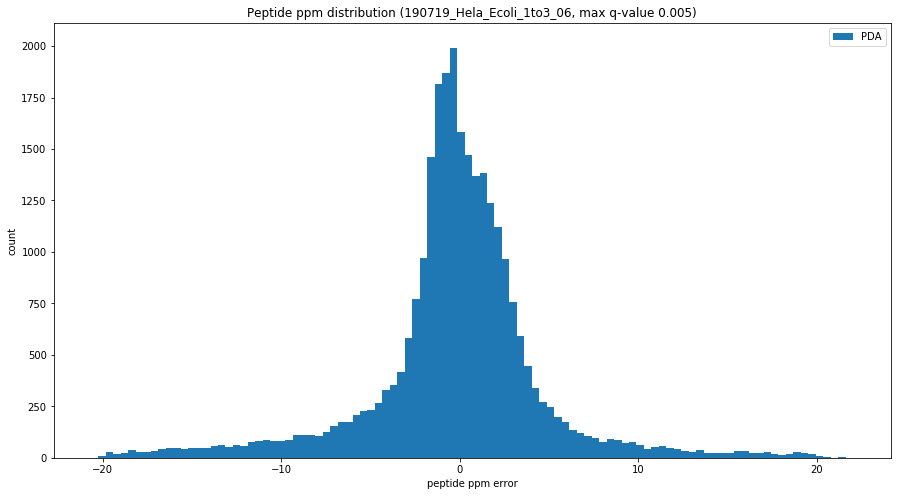

In [213]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide ppm distribution ({}, max q-value {})'.format(mapping[file_idx_to_plot][1], MAXIMUM_Q_VALUE))

bins = 100
hist, bins, _ = plt.hist(percolator_file_subset_df.mass_accuracy_ppm, bins=bins, label='PDA')
plt.legend(loc='best')
plt.xlabel('peptide ppm error')
plt.ylabel('count')

plt.show()

In [505]:
np.std(percolator_file_subset_df.mass_accuracy_ppm.to_numpy())

4.859163200451295

In [399]:
# df = percolator_file_subset_df.loc[(percolator_file_subset_df.rt_apex >= 400) & (percolator_file_subset_df.rt_apex <= 600)]
percolator_file_limited_ppm_df = percolator_file_subset_df[(percolator_file_subset_df.mass_accuracy_ppm >= -10) & (percolator_file_subset_df.mass_accuracy_ppm <= 10)]

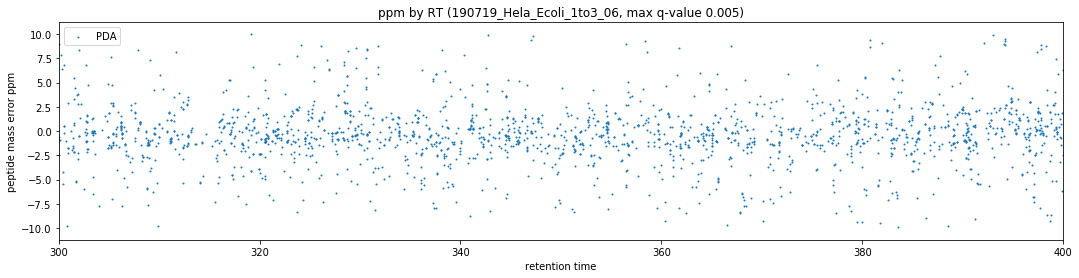

In [511]:
f, ax = plt.subplots()
f.set_figheight(4)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('ppm by RT ({}, max q-value {})'.format(mapping[file_idx_to_plot][1],MAXIMUM_Q_VALUE))

ax.scatter(percolator_file_limited_ppm_df.rt_apex, percolator_file_limited_ppm_df.mass_accuracy_ppm, marker='o', lw=0, s=4, alpha=1.0, label="PDA")

plt.legend(loc='best')
plt.ylabel('peptide mass error ppm')
plt.xlabel('retention time')
plt.xlim((300,400))

plt.show()

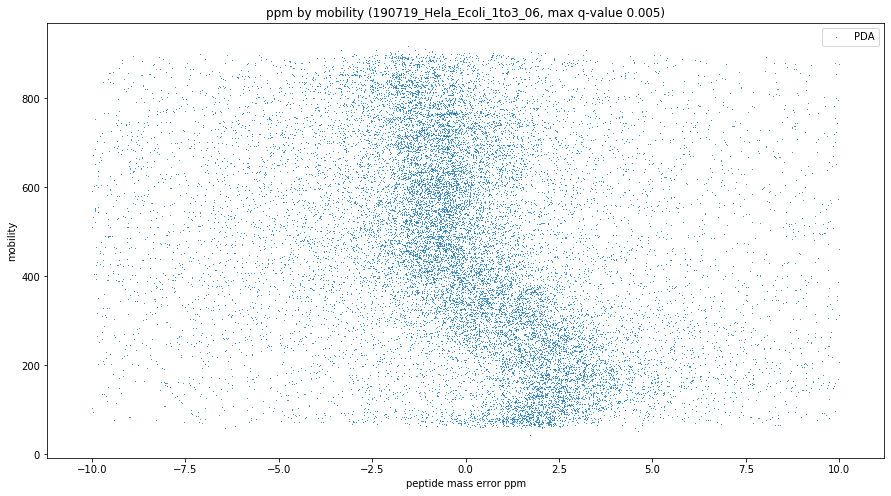

In [401]:
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('ppm by mobility ({}, max q-value {})'.format(mapping[file_idx_to_plot][1],MAXIMUM_Q_VALUE))

ax.scatter(percolator_file_limited_ppm_df.mass_accuracy_ppm, percolator_file_limited_ppm_df.scan_apex, marker='o', lw=0, s=1, alpha=1.0, label="PDA")

plt.legend(loc='best')
plt.xlabel('peptide mass error ppm')
plt.ylabel('mobility')

plt.show()

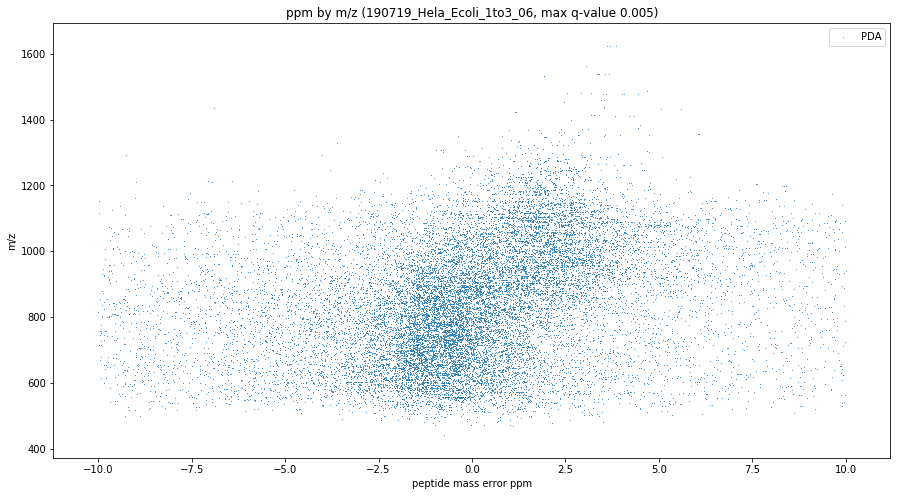

In [402]:
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('ppm by m/z ({}, max q-value {})'.format(mapping[file_idx_to_plot][1],MAXIMUM_Q_VALUE))

ax.scatter(percolator_file_limited_ppm_df.mass_accuracy_ppm, percolator_file_limited_ppm_df.monoisotopic_mz, marker='o', lw=0, s=1, alpha=1.0, label="PDA")

plt.legend(loc='best')
plt.xlabel('peptide mass error ppm')
plt.ylabel('m/z')

plt.show()

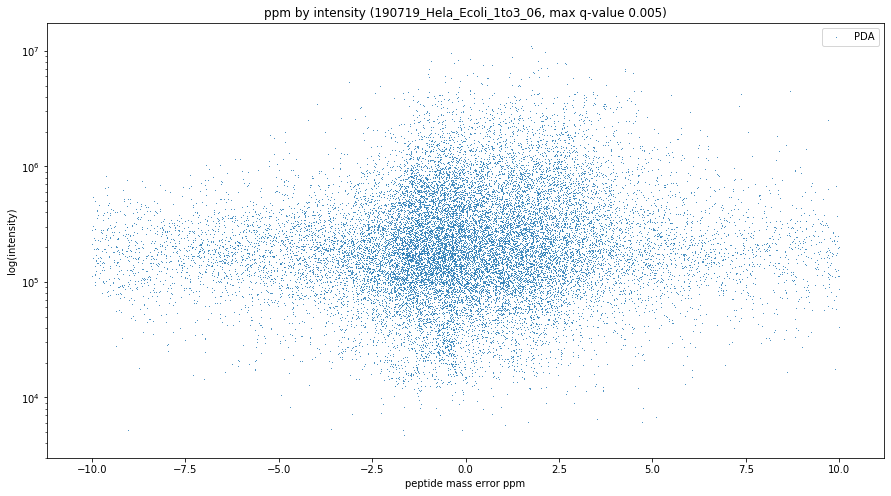

In [403]:
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('ppm by intensity ({}, max q-value {})'.format(mapping[file_idx_to_plot][1],MAXIMUM_Q_VALUE))

ax.scatter(percolator_file_limited_ppm_df.mass_accuracy_ppm, percolator_file_limited_ppm_df.intensity, marker='o', lw=0, s=1, alpha=1.0, label="PDA")

plt.legend(loc='best')
plt.xlabel('peptide mass error ppm')
plt.ylabel('log(intensity)')
ax.set_yscale('log')

plt.show()

In [327]:
# train a model on the features that gave the best identifications to predict the mass error, so we can predict 
# the mass error for all the features detected (not just those with high quality identifications), and adjust 
# their calculated mass to give zero mass error.

In [409]:
X_train_df = percolator_file_limited_ppm_df[['monoisotopic_mz','scan_apex','rt_apex','intensity']]
X_train = X_train_df.to_numpy()

In [410]:
y_train_df = percolator_file_limited_ppm_df[['mass_error']]
y_train = y_train_df.to_numpy()[:,0]

In [411]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import learning_curve,GridSearchCV,ShuffleSplit

In [412]:
gbrt = GradientBoostingRegressor(n_estimators=100)
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [413]:
print("R-squared for training set: {}".format(gbrt.score(X_train, y_train)))

R-squared for training set: 0.22968132804062935


In [414]:
# source: https://shankarmsy.github.io/stories/gbrt-sklearn.html
def GradientBooster(param_grid, n_jobs):
    estimator = GradientBoostingRegressor()
    cv = ShuffleSplit(n_splits=10, train_size=0.8, test_size=.2, random_state=0)
    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs)
    classifier.fit(X_train, y_train)
    print('best estimator found by grid search: {}'.format(classifier.best_estimator_))
    return cv, classifier.best_estimator_


In [422]:
param_grid={'n_estimators':[100], 'learning_rate': [0.1, 0.05, 0.02, 0.01], 'max_depth':[10, 6, 4], 'min_samples_leaf':[3, 5, 9, 17], 'max_features':[1.0, 0.3, 0.1] }
n_jobs = 4

In [423]:
cv,best_estimator = GradientBooster(param_grid, n_jobs)

best estimator found by grid search: GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=10,
                          max_features=1.0, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [424]:
best_estimator.fit(X_train, y_train)
print("R-squared for training set (best model found): {}".format(best_estimator.score(X_train, y_train)))

R-squared for training set (best model found): 0.5909994830022545


In [426]:
features_df.head()

,charge,feature_id,intensity,intensity_full_rt_extent,monoisotopic_mz,rt_apex,scan_apex,percolator_idx,batch
0,2,1,16177434.0,15779061,966.089957,1059.62,152.06,0,1to3
1,2,2,12349904.0,9396591,939.437537,1018.38,143.85,0,1to3
2,2,3,10968797.0,7373639,872.414808,1071.22,360.74,0,1to3
3,2,4,10678154.0,7011464,902.448836,494.21,188.76,0,1to3
4,3,5,10145693.0,4308726,801.419409,1079.44,481.90,0,1to3


In [440]:
filename = mapping[file_idx_to_plot][1]
feature_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/190719_Hela_Ecoli/pkl/{}-features.pkl'.format(filename))

In [441]:
feature_df['monoisotopic_mass'] = (feature_df.monoisotopic_mz * feature_df.charge) - (PROTON_MASS * feature_df.charge)

In [442]:
feature_df.columns

Index(['candidate_phr_error', 'charge', 'envelope', 'feature_id', 'intensity',
       'intensity_full_rt_extent', 'mono_adjusted', 'monoisotopic_mz',
       'original_phr', 'original_phr_error', 'precursor_id', 'rt_apex',
       'rt_curve_fit', 'rt_lower', 'rt_upper', 'scan_apex', 'scan_curve_fit',
       'scan_lower', 'scan_upper', 'monoisotopic_mass'],
      dtype='object')

In [443]:
# use the model to predict the mass error for each feature
X_df = feature_df[['monoisotopic_mz','scan_apex','rt_apex','intensity']]
X = X_df.to_numpy()

In [444]:
feature_df['predicted_mass_error'] = best_estimator.predict(X)

In [445]:
feature_df['recalibrated_mono_mass'] = feature_df.monoisotopic_mass - feature_df.predicted_mass_error

In [448]:
def mono_mass_to_mono_mz(row):
    return (row.recalibrated_mono_mass / row.charge) + PROTON_MASS

In [449]:
feature_df['recalibrated_mono_mz'] = feature_df.apply(lambda row: mono_mass_to_mono_mz(row), axis=1)

In [473]:
# write out the recalibrated features to a pkl so we can regenerate the MGF and search again

In [468]:
RECALIBRATED_MS1_PEAK_PKL = '/Users/darylwilding-mcbride/Downloads/recalibrated_ms1.pkl'

In [469]:
feature_df.to_pickle(RECALIBRATED_MS1_PEAK_PKL)

In [470]:
feature_df.columns

Index(['candidate_phr_error', 'charge', 'envelope', 'feature_id', 'intensity',
       'intensity_full_rt_extent', 'mono_adjusted', 'monoisotopic_mz',
       'original_phr', 'original_phr_error', 'precursor_id', 'rt_apex',
       'rt_curve_fit', 'rt_lower', 'rt_upper', 'scan_apex', 'scan_curve_fit',
       'scan_lower', 'scan_upper', 'monoisotopic_mass', 'predicted_mass_error',
       'recalibrated_mono_mass', 'recalibrated_mono_mz'],
      dtype='object')

In [474]:
# with the new percolator output from the recalibrated MGF, analyse the ppm error

In [493]:
recal_psms_df = pd.read_csv('/Users/darylwilding-mcbride/Downloads/190719_Hela_Ecoli.recalibrated.percolator.target.psms.txt', sep='\t')
recal_psms_df = recal_psms_df[recal_psms_df['percolator q-value'] <= MAXIMUM_Q_VALUE]
recal_psms_df = recal_psms_df[recal_psms_df.file_idx == 0]
recal_psms_df.sort_values(by='scan').head()

,file_idx,scan,charge,spectrum precursor m/z,spectrum neutral mass,peptide mass,percolator score,percolator q-value,percolator PEP,total matches/spectrum,sequence,protein id,flanking aa
31988,0,3,2,871.9097,1741.8048,1742.8120,1.017534,0.000002,3.809511e-09,120781,AMGIMNSFVNDIFER,"sp|Q5QNW6|H2B2F_HUMAN,sp|Q99879|H2B1M_HUMAN,sp...",KI
386086,0,4,2,901.9434,1801.8722,1802.8799,0.514810,0.000002,4.287603e-05,120781,GITINTSHVEYDTPTR,"sp|P0CE48|EFTU2_ECOLI,sp|P0CE47|EFTU1_ECOLI",RH
20085,0,5,3,801.0829,2400.2269,2401.2336,1.072625,0.000002,1.370405e-09,120781,ANDAAGDGTTTATVLAQAIITEGLK,sp|P0A6F5|CH60_ECOLI,KA
259,0,6,2,1093.0818,2184.1490,2128.1350,1.501443,0.000002,4.793864e-13,120781,IPISGIAGDQQAALFGQLCVK,sp|P0A6F3|GLPK_ECOLI,RE
197400,0,7,2,965.5840,1929.1535,1930.1615,0.722762,0.000002,9.050019e-07,120781,VTIAQGGVLPNIQAVLLPK,"sp|Q99878|H2A1J_HUMAN,sp|Q9BTM1|H2AJ_HUMAN,sp|...",KK


In [494]:
recal_features_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/190719_Hela_Ecoli/pkl/190719_Hela_Ecoli_1to3_06-recalibrated-features.pkl')

In [495]:
# because we're just analysing one file (percolator idx 0), we don't need the mapping
recal_percolator_df = pd.merge(recal_psms_df, recal_features_df, how='left', left_on=['scan'], right_on=['feature_id'])

In [496]:
recal_percolator_df = recal_percolator_df[recal_percolator_df['peptide mass'] > 0]

In [497]:
recal_percolator_df.columns

Index(['file_idx', 'scan', 'charge_x', 'spectrum precursor m/z',
       'spectrum neutral mass', 'peptide mass', 'percolator score',
       'percolator q-value', 'percolator PEP', 'total matches/spectrum',
       'sequence', 'protein id', 'flanking aa', 'candidate_phr_error',
       'charge_y', 'envelope', 'feature_id', 'intensity',
       'intensity_full_rt_extent', 'mono_adjusted', 'monoisotopic_mz',
       'original_phr', 'original_phr_error', 'precursor_id', 'rt_apex',
       'rt_curve_fit', 'rt_lower', 'rt_upper', 'scan_apex', 'scan_curve_fit',
       'scan_lower', 'scan_upper', 'monoisotopic_mass', 'predicted_mass_error',
       'recalibrated_mono_mass', 'recalibrated_mono_mz'],
      dtype='object')

In [498]:
recal_percolator_df['monoisotopic_mass'] = (recal_percolator_df.recalibrated_mono_mz * recal_percolator_df.charge_y) - (PROTON_MASS * recal_percolator_df.charge_y)
recal_percolator_df['peptide_mass_mod'] = recal_percolator_df['peptide mass'] + (recal_percolator_df.sequence.str.count('C') * ADD_C_CYSTEINE_DA)
recal_percolator_df['mass_accuracy_ppm'] = (recal_percolator_df['monoisotopic_mass'] - recal_percolator_df['peptide_mass_mod']) / recal_percolator_df['peptide mass'] * 10**6
recal_percolator_df['mass_error'] = recal_percolator_df['monoisotopic_mass'] - recal_percolator_df['peptide_mass_mod']
recal_subset_df = recal_percolator_df[['peptide mass','peptide_mass_mod','monoisotopic_mass','mass_error','mass_accuracy_ppm','sequence']]

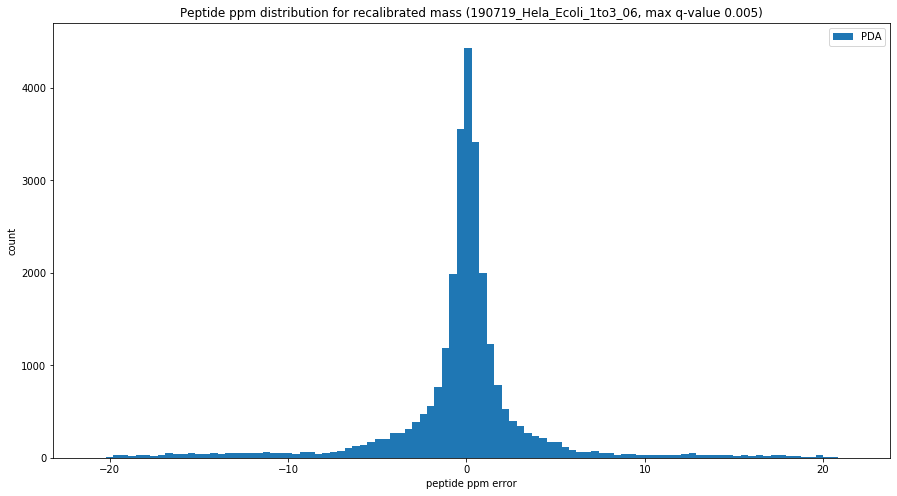

In [502]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide ppm distribution for recalibrated mass ({}, max q-value {})'.format(mapping[file_idx_to_plot][1], MAXIMUM_Q_VALUE))

bins = 100
hist, bins, _ = plt.hist(recal_percolator_df.mass_accuracy_ppm, bins=bins, label='PDA')
plt.legend(loc='best')
plt.xlabel('peptide ppm error')
plt.ylabel('count')

plt.show()

In [504]:
np.std(recal_percolator_df.mass_accuracy_ppm.to_numpy())

4.3018035191429185

In [506]:
recal_percolator_df = recal_percolator_df[(recal_percolator_df.mass_accuracy_ppm >= -10) & (recal_percolator_df.mass_accuracy_ppm <= 10)]

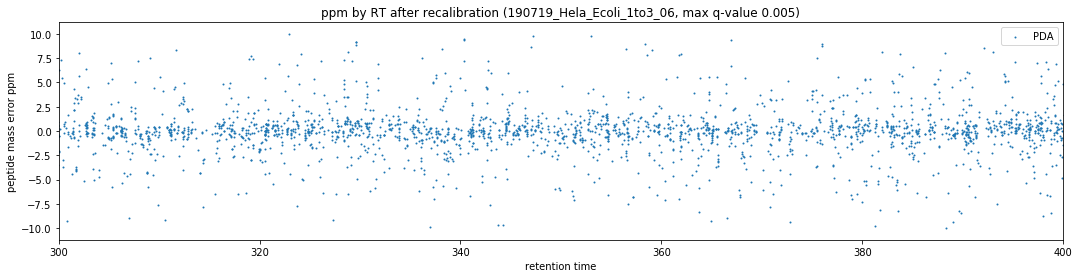

In [510]:
f, ax = plt.subplots()
f.set_figheight(4)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('ppm by RT after recalibration ({}, max q-value {})'.format(mapping[file_idx_to_plot][1],MAXIMUM_Q_VALUE))

ax.scatter(recal_percolator_df.rt_apex, recal_percolator_df.mass_accuracy_ppm, marker='o', lw=0, s=4, alpha=1.0, label="PDA")

plt.legend(loc='best')
plt.ylabel('peptide mass error ppm')
plt.xlabel('retention time')
plt.xlim((300,400))

plt.show()

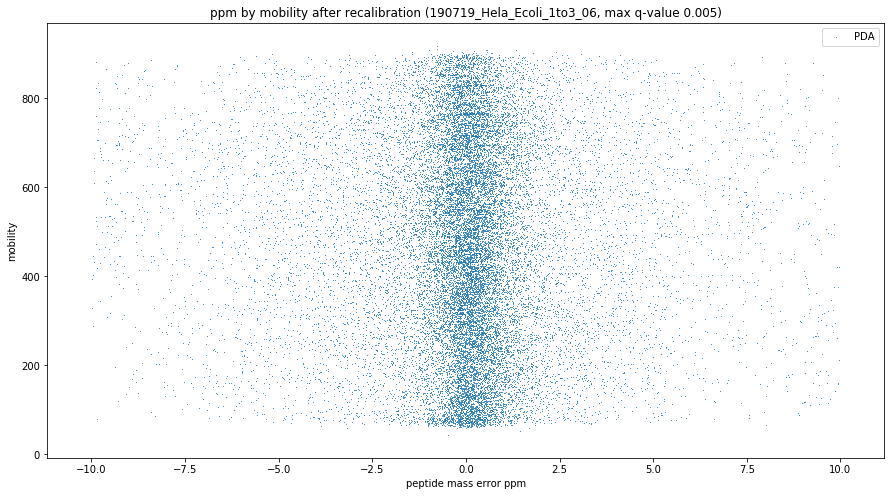

In [508]:
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('ppm by mobility after recalibration ({}, max q-value {})'.format(mapping[file_idx_to_plot][1],MAXIMUM_Q_VALUE))

ax.scatter(recal_percolator_df.mass_accuracy_ppm, recal_percolator_df.scan_apex, marker='o', lw=0, s=1, alpha=1.0, label="PDA")

plt.legend(loc='best')
plt.xlabel('peptide mass error ppm')
plt.ylabel('mobility')

plt.show()

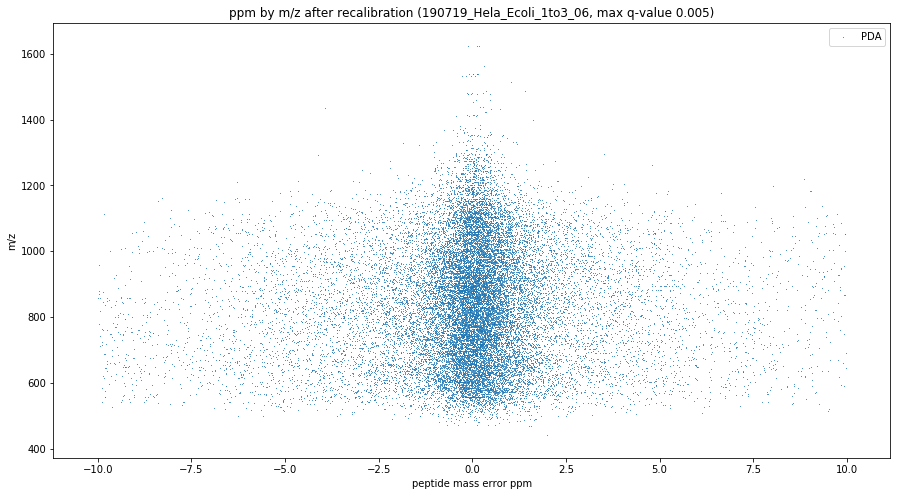

In [509]:
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('ppm by m/z after recalibration ({}, max q-value {})'.format(mapping[file_idx_to_plot][1],MAXIMUM_Q_VALUE))

ax.scatter(recal_percolator_df.mass_accuracy_ppm, recal_percolator_df.monoisotopic_mz, marker='o', lw=0, s=1, alpha=1.0, label="PDA")

plt.legend(loc='best')
plt.xlabel('peptide mass error ppm')
plt.ylabel('m/z')

plt.show()